In [1]:
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Input,Dropout#core layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D#convolution layers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import CategoricalCrossentropy
import optuna

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#trainデータの読み込み・目的変数と説明変数の分離
train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")

train_x = train.drop(['label'],axis=1)
train_y = train['label']

#testデータの読み込み
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

In [3]:
#trainデータを4分割し、訓練用：バリデーションを3:1にする
kf = KFold(n_splits=4, shuffle=True, random_state=71)

tr_idx, va_idx = list(kf.split(train_x))[0]#index取得
tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

#画像pixel値を255で割って正規化・numpy配列に変換
tr_x, va_x = np.array(tr_x/255.0),np.array(va_x/255.0)

In [4]:
#画像データを2→3階テンソルに変換(高さ=28px,幅=28px,チャンネル=1)
#グレースケールなのでチャンネル=1
tr_x = tr_x.reshape(-1,28,28,1)
va_x = va_x.reshape(-1,28,28,1)

#正解ラベルをOne-Hot表現化
tr_y = to_categorical(tr_y,10)#numpy.ndarray
va_y = to_categorical(va_y,10)#numpy.ndarray

print(tr_x.shape,tr_y.shape,va_x.shape,va_y.shape)

(31500, 28, 28, 1) (31500, 10) (10500, 28, 28, 1) (10500, 10)


In [16]:
# CNN基盤のクラスSequentialを生成し、第1層を定義
model = Sequential([
    Input(shape=(28, 28, 1)),#入力データの形状
    Conv2D(
        filters=32,#フィルター数
        kernel_size=(5,5),#5*5のフィルターを使用
        padding='same',#ゼロパディング
        activation='relu'#活性化関数
    )
])

#Flatten層を配置して、2次元データを1次元データにフラット化
model.add(Flatten())

#第2層（出力層）
model.add(
    Dense(
        10,  # ニューロン数
        activation='softmax'  # マルチクラス分類に適したsoftmaxを指定（各クラスの確率を出す）
    ))

In [17]:
model.compile(
    loss='categorical_crossentropy',#損失関数：クロスエントロピー誤差
    optimizer='rmsprop',#オプティマイザー：RMSprop
    metrics=['accuracy']#学習評価：正解率
)

model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 32)          │             832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │         250,890 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 251,722 (983.29 KB)

 Trainable params: 251,722 (983.29 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
#学習して結果を出力
history = model.fit(
    tr_x,
    tr_y,
    epochs=20,#学習回数
    batch_size=100,#ミニバッチサイズ
    validation_data=(va_x,va_y),#検証用データの指定
    verbose=1#学習の進捗表示
)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 32ms/step - accuracy: 0.8469 - loss: 0.4996 - val_accuracy: 0.9616 - val_loss: 0.1246
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9725 - loss: 0.1000 - val_accuracy: 0.9746 - val_loss: 0.0891
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 30ms/step - accuracy: 0.9828 - loss: 0.0620 - val_accuracy: 0.9784 - val_loss: 0.0729
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9862 - loss: 0.0471 - val_accuracy: 0.9784 - val_loss: 0.0737
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9892 - loss: 0.0368 - val_accuracy: 0.9793 - val_loss: 0.0673
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step - accuracy: 0.9904 - loss: 0.0308 - val_accuracy: 0.9810 - val_loss: 0.0663
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 31ms/step - accuracy: 0.9929 - loss: 0.0257 - val_accuracy: 0.9812 - val_loss: 0.0717
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.9948 - loss: 0.0205 - val

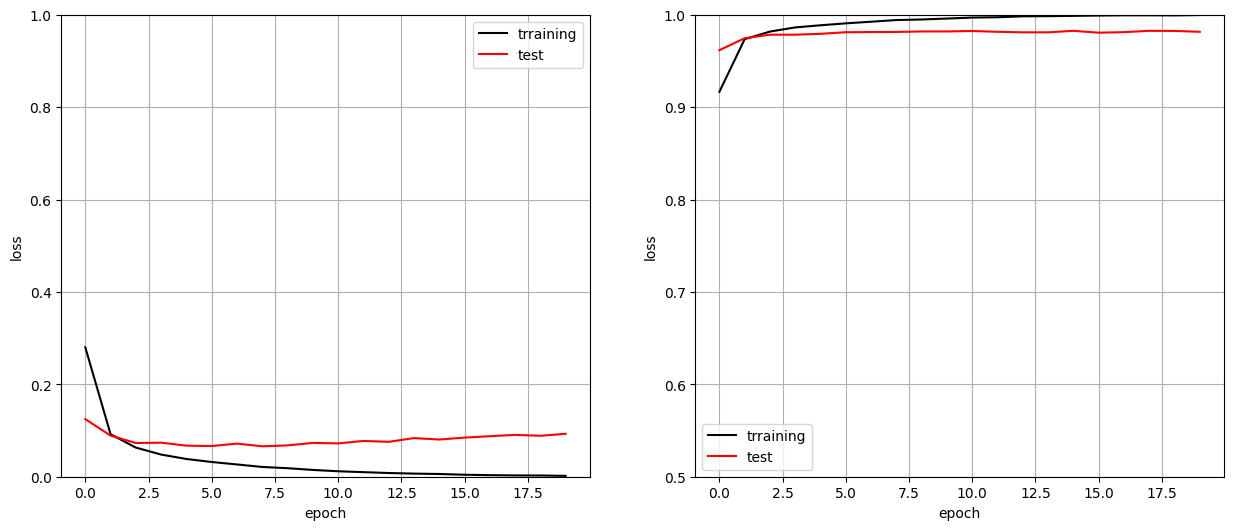

In [20]:
#損失と正解率の推移をグラフ化
plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.2)#図を縮小して間のスペースを開ける
plt.subplot(1,2,1)#1*2グリッドの左(1,2,1)の領域にプロット
#train_lossをプロット
plt.plot(history.history['loss'],
         label='trraining',
         color='black')
#valid_lossをプロット
plt.plot(history.history['val_loss'],
         label='test',
         color='red')
plt.ylim(0,1)#y軸の範囲
plt.legend()#凡例を表示
plt.grid()#グリッドを表示
plt.xlabel('epoch')
plt.ylabel('loss')

#1*2のグリッドの右(1,2,2)の領域にプロット
plt.subplot(1,2,2)
#train_accuracyをプロット
plt.plot(history.history['accuracy'],
         label='trraining',
         color='black')
#valid_accuracyをプロット
plt.plot(history.history['val_accuracy'],
         label='test',
         color='red')
plt.ylim(0.5,1)#y軸の範囲
plt.legend()#凡例を表示
plt.grid()#グリッドを表示
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [2]:
#データ前処理関数
def prepare_data():#データ作成関数
    #trainデータの読み込み・目的変数と説明変数の分離
    train = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
    train_x = train.drop(['label'],axis=1)
    train_y = train['label']

    #trainデータを4分割し、訓練用：バリデーションを3:1にする
    kf = KFold(n_splits=4, shuffle=True, random_state=123)
    tr_idx, va_idx = list(kf.split(train_x))[0]#index取得
    tr_x, va_x = train_x.iloc[tr_idx], train_x.iloc[va_idx]
    tr_y, va_y = train_y.iloc[tr_idx], train_y.iloc[va_idx]

    #画像pixel値を255で割って正規化・numpy配列に変換
    tr_x, va_x = np.array(tr_x/255.0),np.array(va_x/255.0)

    #画像データを2→3階テンソルに変換(高さ=28px,幅=28px,チャンネル=1)
    #グレースケールなのでチャンネル=1
    tr_x = tr_x.reshape(-1,28,28,1)
    va_x = va_x.reshape(-1,28,28,1)

    #正解ラベルをOne-Hot表現化
    tr_y = to_categorical(tr_y,10)#numpy.ndarray
    va_y = to_categorical(va_y,10)#numpy.ndarray

    return tr_x,tr_y,va_x,va_y

In [12]:
# モデル構築を試行する関数
def objective(trial):
    # データを取得
    tr_x, tr_y, va_x, va_y = prepare_data()

    # CNN基盤のクラスSequentialを生成し、第1層を定義
    filters_first = trial.suggest_categorical('filters_first', [32, 64])
    kernel_first_size = trial.suggest_categorical('kernel_first', [3, 5, 7])
    kernel_first = (kernel_first_size, kernel_first_size)  # タプルに変換
    activation_first = trial.suggest_categorical('activation_first', ['tanh', 'relu'])

    model = Sequential([
        Input(shape=(28, 28, 1)),  # 入力データの形状
        Conv2D(filters=filters_first, kernel_size=kernel_first, padding='same', activation=activation_first)
    ])

    # 第2層
    filters_second = trial.suggest_categorical('filters_second', [32, 64])
    kernel_second_size = trial.suggest_categorical('kernel_second', [3, 5, 7])
    kernel_second = (kernel_second_size, kernel_second_size)  # タプルに変換
    activation_second = trial.suggest_categorical('activation_second', ['tanh', 'relu'])
    model.add(Conv2D(filters=filters_second, kernel_size=kernel_second, padding='same', activation=activation_second))

    # 第3層（2*2のプーリング層）
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ドロップアウト率探索
    dropout_first = trial.suggest_float('dropout_first', 0.2, 0.6, step=0.05)
    model.add(Dropout(dropout_first))

    # 第4層
    filters_3 = trial.suggest_categorical('filters_3', [32, 64])
    kernel_3_size = trial.suggest_categorical('kernel_3', [3, 5, 7])
    kernel_3 = (kernel_3_size, kernel_3_size)
    activation_3 = trial.suggest_categorical('activation_3', ['tanh', 'relu'])
    model.add(Conv2D(filters=filters_3, kernel_size=kernel_3, padding='same', activation=activation_3))

    # 第5層
    filters_4 = trial.suggest_categorical('filters_4', [32, 64])
    kernel_4_size = trial.suggest_categorical('kernel_4', [3, 5, 7])
    kernel_4 = (kernel_4_size, kernel_4_size)
    activation_4 = trial.suggest_categorical('activation_4', ['tanh', 'relu'])
    model.add(Conv2D(filters=filters_4, kernel_size=kernel_4, padding='same', activation=activation_4))

    # 第6層（2*2のプーリング層）
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # ドロップアウト率探索
    dropout_2 = trial.suggest_float('dropout_2', 0.2, 0.6, step=0.05)
    model.add(Dropout(dropout_2))

    # Flatten層
    model.add(Flatten())

    # 追加する層を(1,2)から選択
    n_layers = trial.suggest_categorical('n_layers', ['none', 'one', 'two'])
    if n_layers in ['one', 'two']:
        n_units_first = trial.suggest_categorical('units_first', [500, 600, 700])
        activation_5 = trial.suggest_categorical('activation_5', ['tanh', 'relu'])
        model.add(Dense(n_units_first, activation=activation_5))
        dropout_3 = trial.suggest_float('dropout_3', 0.1, 0.6, step=0.05)
        model.add(Dropout(dropout_3))

    if n_layers == 'two':
        n_units_2 = trial.suggest_categorical('units_2', [100, 150, 200])
        activation_6 = trial.suggest_categorical('activation_6', ['tanh', 'relu'])
        model.add(Dense(n_units_2, activation=activation_6))
        dropout_4 = trial.suggest_float('dropout_4', 0.2, 0.6, step=0.05)
        model.add(Dropout(dropout_4))

    # 出力層
    model.add(Dense(10, activation="softmax"))

    # オプティマイザの選択と学習率の探索
    optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'rmsprop'])
    #learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    optimizer = Adam() if optimizer_name == 'adam' else RMSprop()

    # モデルのコンパイル
    model.compile(
        optimizer=optimizer,
        loss=CategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    epoch = 30
    batch_size = trial.suggest_categorical('batch_size', [100, 200, 300])
    history = model.fit(
        tr_x, tr_y,
        epochs=epoch,
        batch_size=batch_size,
        validation_data=(va_x, va_y),
        verbose=0
    )

    # 検証精度の最大値を返す
    validation_acc = max(history.history['val_accuracy'])
    return validation_acc

In [ ]:
# Optunaのチューニング実行
study = optuna.create_study(direction='maximize')  # maximize に変更
study.optimize(objective, n_trials=50)

# 最適なパラメータとモデル
print("Best trial:")
print(study.best_trial.params)

[I 2025-02-08 17:39:48,679] A new study created in memory with name: no-name-d9308ce4-0728-4b28-ab13-aaee9cd4028c
[I 2025-02-08 19:04:29,293] Trial 0 finished with value: 0.9921904802322388 and parameters: {'filters_first': 32, 'kernel_first': 3, 'activation_first': 'relu', 'filters_second': 64, 'kernel_second': 5, 'activation_second': 'tanh', 'dropout_first': 0.55, 'filters_3': 32, 'kernel_3': 3, 'activation_3': 'relu', 'filters_4': 64, 'kernel_4': 7, 'activation_4': 'tanh', 'dropout_2': 0.5, 'n_layers': 'none', 'optimizer': 'rmsprop', 'batch_size': 100}. Best is trial 0 with value: 0.9921904802322388.


In [20]:
#チューニング後の最適モデルを構築
tr_x, tr_y, va_x, va_y = prepare_data()

# CNN基盤のクラスSequentialを生成し、第1層を定義
model = Sequential([
    Input(shape=(28, 28, 1)),  # 入力データの形状
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu')
])

# 第2層
model.add(Conv2D(filters=64, kernel_size=5, padding='same', activation='tanh'))

# 第3層（2*2のプーリング層）
model.add(MaxPooling2D(pool_size=(2, 2)))

# ドロップアウト率探索
model.add(Dropout(0.3))

# 第4層
model.add(Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'))

# 第5層
model.add(Conv2D(filters=64, kernel_size=7, padding='same', activation='tanh'))

# 第6層（2*2のプーリング層）
model.add(MaxPooling2D(pool_size=(2, 2)))

# ドロップアウト率探索
model.add(Dropout(0.3))

# Flatten層
model.add(Flatten())

# 出力層
model.add(Dense(10, activation="softmax"))

# オプティマイザの選択と学習率の探索
optimizer = RMSprop()

# モデルのコンパイル
model.compile(
    optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

epoch = 20
history = model.fit(
    tr_x, tr_y,
    epochs=epoch,
    batch_size=100,
    validation_data=(va_x, va_y),
    verbose=1
)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8522 - loss: 0.4392 - val_accuracy: 0.9793 - val_loss: 0.0674
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9755 - loss: 0.0779 - val_accuracy: 0.9798 - val_loss: 0.0645
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9828 - loss: 0.0531 - val_accuracy: 0.9851 - val_loss: 0.0506
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9872 - loss: 0.0429 - val_accuracy: 0.9857 - val_loss: 0.0488
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9899 - loss: 0.0332 - val_accuracy: 0.9872 - val_loss: 0.0425
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9907 - loss: 0.0293 - val_accuracy: 0.9899 - val_loss: 0.0399
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9918 - loss: 0.0249 - val_accuracy: 0.9899 - val_loss: 0.0384
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9941 - loss: 0.0196 - val_accuracy: 0

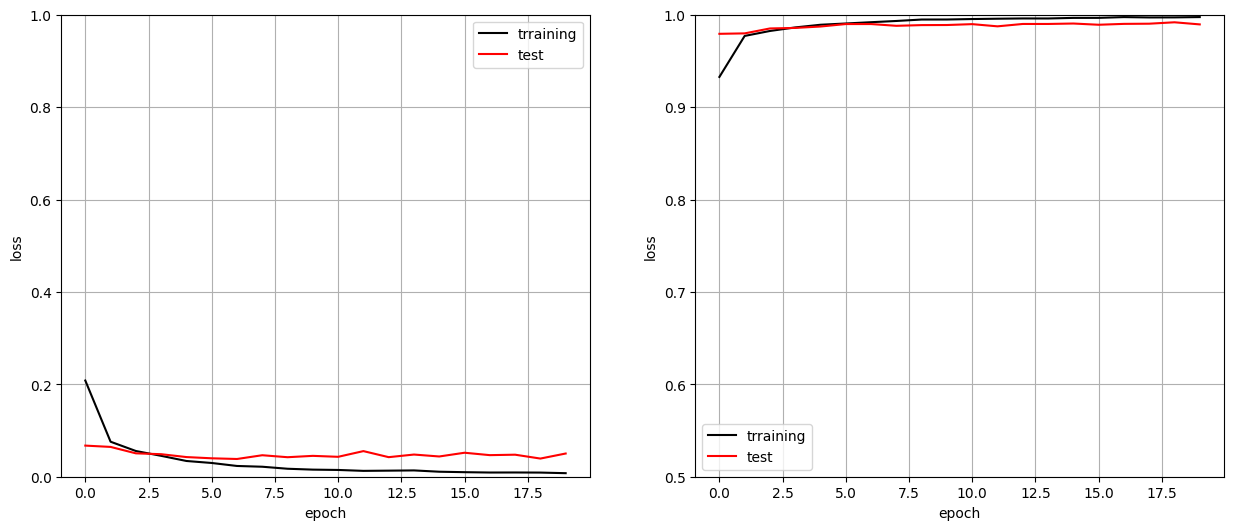

In [27]:
#損失と正解率の推移をグラフ化
plt.figure(figsize=(15,6))
plt.subplots_adjust(wspace=0.2)#図を縮小して間のスペースを開ける
plt.subplot(1,2,1)#1*2グリッドの左(1,2,1)の領域にプロット
#train_lossをプロット
plt.plot(history.history['loss'],
         label='trraining',
         color='black')
#valid_lossをプロット
plt.plot(history.history['val_loss'],
         label='test',
         color='red')
plt.ylim(0,1)#y軸の範囲
plt.legend()#凡例を表示
plt.grid()#グリッドを表示
plt.xlabel('epoch')
plt.ylabel('loss')

#1*2のグリッドの右(1,2,2)の領域にプロット
plt.subplot(1,2,2)
#train_accuracyをプロット
plt.plot(history.history['accuracy'],
         label='trraining',
         color='black')
#valid_accuracyをプロット
plt.plot(history.history['val_accuracy'],
         label='test',
         color='red')
plt.ylim(0.5,1)#y軸の範囲
plt.legend()#凡例を表示
plt.grid()#グリッドを表示
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

In [32]:
#拡張データを使って学習を行う
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#データ拡張
datagen = ImageDataGenerator(
    width_shift_range = 0.1,#水平移動
    height_shift_range=0.1,#垂直移動
    rotation_range=10,#回転
    zoom_range=0.1#拡大
)

batch_size = 100
epochs = 20

#学習実行
history = model.fit(
    #拡張データをミニバッチ数生成（出力は正規化）
    datagen.flow(tr_x,tr_y,batch_size=batch_size,shuffle=True),
    #1回の学習におけるステップ数（画像枚数をミニバッチサイズで割った整数値）
    steps_per_epoch = tr_x.shape[0] // batch_size,
    epochs = epochs,
    verbose = 1,
    validation_data = (va_x,va_y)
)

Epoch 1/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 33ms/step - accuracy: 0.9860 - loss: 0.0564 - val_accuracy: 0.9931 - val_loss: 0.0314
Epoch 2/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9931 - val_loss: 0.0314
Epoch 3/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.9861 - loss: 0.0573 - val_accuracy: 0.9925 - val_loss: 0.0339
Epoch 4/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9925 - val_loss: 0.0339
Epoch 5/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9863 - loss: 0.0617 - val_accuracy: 0.9905 - val_loss: 0.0401
Epoch 6/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.9905 - val_loss: 0.0401
Epoch 7/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9847 - loss: 0.0609 - val_accuracy: 0.9932 - val_loss: 0.0247
Epoch 8/20
315/315 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0000e+